In [2]:
from enum import Enum
from string import ascii_letters
from random import randint, uniform, choice, choices

import io
import os
import json
import requests
import jsonschema
from time import perf_counter

from multiprocessing import Pool, cpu_count
from concurrent.futures import ThreadPoolExecutor

from typing import Literal, Any, Iterable
from pprint import pprint  # Pretty Print for debugging

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots  # noqa: F401

from sqlalchemy import text

from core.database_sql import SessionLocal, engine  # noqa: E402

SpreadsheetType = Literal["csv", "xlsx", "xls"]

formats: dict[SpreadsheetType, dict[str, str]] = {
    "csv": {"folder": "csv"},
    "xlsx": {"folder": "excel"},
    "xls": {"folder": "excel"},
}

In [82]:
# LaTeX must be installed previously for this to work
plt.style.use(["science", "ieee"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Helvetica", "Times New Roman", "Times", "DejaVu Serif"],
        "font.size": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.labelsize": 10,
        "legend.fontsize": 9,
        "axes.titlesize": 11,
        "figure.titlesize": 12,
        "text.usetex": True,  # Desactivar LaTeX si hay problemas de fuentes
        "pdf.fonttype": 42,  # Usar TrueType fonts en PDF (embebidas)
        "ps.fonttype": 42,  # Usar TrueType fonts en PostScript
        "savefig.format": "pdf",
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
        "figure.dpi": 300,
        "savefig.dpi": 300,
    }
)

In [22]:
def get_ranges_int(bits: int, unsigned: bool = False) -> tuple[int, int]:
    """Return the range of values for a given bit width."""
    if unsigned:
        return (0, 2**bits - 1)
    return (-(2 ** (bits - 1)), 2 ** (bits - 1) - 1)


def get_ranges_float(bits: int) -> tuple[float, float]:
    """Return the range of values for a given float bit width."""
    if bits == 32:
        return (-3.4028235e38, 3.4028235e38)

    if bits == 64:
        return (-1.7976931348623157e308, 1.7976931348623157e308)

    raise ValueError("Unsupported float bit width.")


datatype_ranges = {
    **{
        f"Int{bits}": {"type": "integer", "range": get_ranges_int(bits, False)}
        for bits in [8, 16, 32, 64, 128]
    },
    **{
        f"UInt{bits}": {"type": "integer", "range": get_ranges_int(bits, True)}
        for bits in [8, 16, 32, 64]
    },
    **{
        f"Float{bits}": {"type": "number", "range": get_ranges_float(bits)}
        for bits in [32, 64]
    },
    "Boolean": {"type": "boolean"},
    "String": {"type": "string"},
}

pprint(datatype_ranges)

{'Boolean': {'type': 'boolean'},
 'Float32': {'range': (-3.4028235e+38, 3.4028235e+38), 'type': 'number'},
 'Float64': {'range': (-1.7976931348623157e+308, 1.7976931348623157e+308),
             'type': 'number'},
 'Int128': {'range': (-170141183460469231731687303715884105728,
                      170141183460469231731687303715884105727),
            'type': 'integer'},
 'Int16': {'range': (-32768, 32767), 'type': 'integer'},
 'Int32': {'range': (-2147483648, 2147483647), 'type': 'integer'},
 'Int64': {'range': (-9223372036854775808, 9223372036854775807),
           'type': 'integer'},
 'Int8': {'range': (-128, 127), 'type': 'integer'},
 'String': {'type': 'string'},
 'UInt16': {'range': (0, 65535), 'type': 'integer'},
 'UInt32': {'range': (0, 4294967295), 'type': 'integer'},
 'UInt64': {'range': (0, 18446744073709551615), 'type': 'integer'},
 'UInt8': {'range': (0, 255), 'type': 'integer'}}


## Generate spreadsheets and its jsonschema for validation

In [4]:
def random_string(length: int = 10) -> str:
    """Generate a random string of fixed length."""
    return "".join(choice(ascii_letters) for _ in range(length))


class DataType(Enum):
    """Enum for data types."""

    # Some data types are commented out for practical purposes.
    Int8 = {
        "name": "Int8",
        "random_data": lambda: randint(*get_ranges_int(8, False)),
        "polars": pl.Int8,
    }
    Int16 = {
        "name": "Int16",
        "random_data": lambda: randint(*get_ranges_int(16, False)),
        "polars": pl.Int16,
    }
    Int32 = {
        "name": "Int32",
        "random_data": lambda: randint(*get_ranges_int(32, False)),
        "polars": pl.Int32,
    }
    # Int64 = {
    #     "name": "Int64",
    #     "random_data": lambda: randint(*get_ranges_int(64, False)),
    #     "polars": pl.Int64,
    # }
    # Int128 = {
    #     "name": "Int128",
    #     "random_data": lambda: randint(*get_ranges_int(128, False)),
    #     "polars": pl.Int128,
    # }
    UInt8 = {
        "name": "UInt8",
        "random_data": lambda: randint(*get_ranges_int(8, True)),
        "polars": pl.UInt8,
    }
    UInt16 = {
        "name": "UInt16",
        "random_data": lambda: randint(*get_ranges_int(16, True)),
        "polars": pl.UInt16,
    }
    UInt32 = {
        "name": "UInt32",
        "random_data": lambda: randint(*get_ranges_int(32, True)),
        "polars": pl.UInt32,
    }
    # UInt64 = {
    #     "name": "UInt64",
    #     "random_data": lambda: randint(*get_ranges_int(64, True)),
    #     "polars": pl.UInt64,
    # }
    Float32 = {
        "name": "Float32",
        "random_data": lambda: uniform(*get_ranges_float(32)),
        "polars": pl.Float32,
    }
    # Float64 = {
    #     "name": "Float64",
    #     "random_data": lambda: uniform(*get_ranges_float(64)),
    #     "polars": pl.Float64,
    # }
    Boolean = {
        "name": "Boolean",
        "random_data": lambda: choice([True, False]),
        "polars": pl.Boolean,
    }
    String = {
        "name": "String",
        "random_data": lambda: random_string(randint(1, 20)),
        "polars": pl.String,
    }

In [23]:
def generate_jsonschema(df: pl.DataFrame) -> dict:
    """
    Generates a JSON schema with the specified number of rows and columns.
    Each column will have a unique name and type 'integer'.
    """
    properties = {}
    for col, dtype in df.schema.items():
        dtype_str = str(dtype)
        if dtype_str not in datatype_ranges:
            print(f"Unsupported data type: {dtype_str}")
            continue

        dtype_info = datatype_ranges[dtype_str]
        properties[col] = {"type": dtype_info["type"]}
        if "range" in dtype_info:
            properties[col]["minimum"] = dtype_info["range"][0]
            properties[col]["maximum"] = dtype_info["range"][1]

    schema = {
        "$schema": "http://json-schema.org/draft-07/schema#",
        "type": "object",
        "properties": properties,
        "required": list(properties.keys()),
        "additionalProperties": False,
    }

    return schema


def generate_spreadsheet(
    rows: int, columns: int, path: str = "./data", format: SpreadsheetType = "xlsx"
) -> bool:
    """
    Generates a CSV file with the specified number of rows and columns.
    Each column will have a unique name and random integer values.
    """

    def generate_data(dtype: DataType, size: int) -> list:
        """Generate a list of random data based on the DataType."""
        return [dtype.value["random_data"]() for _ in range(size)]

    dtype_options = list(DataType)
    options = choices(dtype_options, k=columns)
    data = {
        f"col_{i}-{opt.value['name']}": pl.Series(generate_data(opt, size=rows))
        for i, opt in enumerate(options)
    }

    df = pl.DataFrame(data)

    # Save the DataFrame to a CSV file
    try:
        if format == "csv":
            df.write_csv(f"{path}/data_rows-{rows}_columns-{columns}.{format}")

        if format in ["xlsx", "xls"]:
            # Polars with floats numbers is horrible, export numbers like 1.1,3
            df.to_pandas().to_excel(
                f"{path}/data_rows-{rows}_columns-{columns}.{format}",
                index=False,
                engine="openpyxl",
            )
    except Exception as e:
        print(f"Failed to save the file in {format} format. -> {repr(e)}")
        return False

    # Save the JSON schema
    schema = generate_jsonschema(df)
    with open(f"{path}/schema_rows-{rows}_columns-{columns}.json", "w") as f:
        f.write(json.dumps(schema, indent=2))

    return True

In [24]:
# Generate csvs with fixed number of rows and varying columns
rows_fixed = 1000
format: SpreadsheetType = "csv"
path_rows = os.path.join("data", formats[format]["folder"], f"rows-{rows_fixed}")
os.makedirs(path_rows, exist_ok=True)

for i in range(100, 1001, 100):
    print(f"Generating spreadsheet with {rows_fixed} rows and {i} columns...")
    generate_spreadsheet(rows_fixed, i, path=path_rows, format=format)

Generating spreadsheet with 1000 rows and 100 columns...
Generating spreadsheet with 1000 rows and 200 columns...
Generating spreadsheet with 1000 rows and 300 columns...
Generating spreadsheet with 1000 rows and 400 columns...
Generating spreadsheet with 1000 rows and 500 columns...
Generating spreadsheet with 1000 rows and 600 columns...
Generating spreadsheet with 1000 rows and 700 columns...
Generating spreadsheet with 1000 rows and 800 columns...
Generating spreadsheet with 1000 rows and 900 columns...
Generating spreadsheet with 1000 rows and 1000 columns...


In [75]:
# Generate csvs with fixed number of columns and varying rows
columns_fixed = 100
format: SpreadsheetType = "csv"
path_columns = os.path.join(
    "data", formats[format]["folder"], f"columns-{columns_fixed}"
)
os.makedirs(path_columns, exist_ok=True)
for i in range(1000, 10001, 1000):
    print(f"Generating spreadsheet with {i} rows and {columns_fixed} columns...")
    generate_spreadsheet(i, columns_fixed, path=path_columns, format=format)

Generating spreadsheet with 1000 rows and 100 columns...
Generating spreadsheet with 2000 rows and 100 columns...
Generating spreadsheet with 3000 rows and 100 columns...
Generating spreadsheet with 4000 rows and 100 columns...
Generating spreadsheet with 5000 rows and 100 columns...
Generating spreadsheet with 6000 rows and 100 columns...
Generating spreadsheet with 7000 rows and 100 columns...
Generating spreadsheet with 8000 rows and 100 columns...
Generating spreadsheet with 9000 rows and 100 columns...
Generating spreadsheet with 10000 rows and 100 columns...


In [58]:
# Big files (so much time to generate [1 GB, 3 GB, 5 GB, 7 GB])
# rows_fixed = 10_000
# path_columns = os.path.join("data", "excel", "big_files")
# os.makedirs(path_columns, exist_ok=True)
# for i in (12500, 37500, 62500, 87500):
#     print(f"Generating file with {rows_fixed} rows and {i} columns")
#     generate_spreadsheet(rows_fixed, i, path=path_columns, format="xlsx")

## Execution time

### Utils

In [4]:
def validate_chunks_mp(args):
    data, schema = args
    errors = []
    valid_count = 0

    for i, item in enumerate(data):
        try:
            jsonschema.validate(instance=item, schema=schema)
            valid_count += 1
        except Exception as e:
            errors.append(f"Item {i}: {str(e)}")

    return valid_count, errors


def validate_spreadsheet_optimized(
    path: str, n_workers: int = None, schema: dict = None
) -> tuple[pl.DataFrame, dict]:
    if n_workers is None:
        n_workers = min(cpu_count(), 8)  # Limitar workers

    format = os.path.splitext(path)[-1].lower()
    if format == ".csv":
        df = pl.read_csv(path)
    if format in [".xlsx", ".xls"]:
        df = pl.read_excel(path, engine="openpyxl")

    if not schema:
        schema_path = (
            os.path.basename(path).replace(format, ".json").replace("data", "schema")
        )
        schema_path = os.path.join(os.path.dirname(path), schema_path)
        with open(schema_path, "r") as f:
            schema = json.load(f)

    data_dicts = df.to_dicts()

    chunk_size = max(1, len(data_dicts) // n_workers)
    chunks = []
    for i in range(0, len(data_dicts), chunk_size):
        chunk = data_dicts[i : i + chunk_size]
        chunks.append((chunk, schema))

    with Pool(processes=n_workers) as pool:
        results = pool.map(validate_chunks_mp, chunks)

    total_valid = sum(result[0] for result in results)
    all_errors = []
    for result in results:
        all_errors.extend(result[1])

    df.columns = list(map(lambda x: x.replace(" ", "_"), df.columns))

    validation_summary = {
        "total_items": len(data_dicts),
        "valid_items": total_valid,
        "invalid_items": len(data_dicts) - total_valid,
        "errors": all_errors[:50],
    }

    return df, validation_summary

In [ ]:
def generate_metadata_from_jsonschema(
    schema: dict, sheet_name: str
) -> dict[str, dict[str, str]]:
    """
    Generate metadata from a JSON schema.
    The metadata will be used to create the SQL table.
    """
    dtypes = {}
    for col, properties in schema["properties"].items():
        dtype = properties["type"]

        dtype_str = col.split("-")[-1]  # Get the last part of the column name
        dtype_range = datatype_ranges.get(dtype_str, None)
        ranges = dtype_range.get("range", None) if dtype_range else None
        min_val, max_val = ranges if ranges else (None, None)

        col_no_spaces = col.replace(" ", "_")
        extra = "NOT NULL" if col in schema.get("required", []) else ""
        if dtype == "integer":
            if min_val is None or max_val is None:
                dtypes[col_no_spaces] = {"type": "BIGINT", "extra": extra}

            # Don't know what's happening exactly that this doesn't work as expected
            # elif min_val >= -32768 and max_val <= 32767:
            #     dtypes[col_no_spaces] = {"type": "SMALLINT", "extra": extra}

            elif min_val >= -2147483648 and max_val <= 2147483647:
                dtypes[col_no_spaces] = {"type": "INTEGER", "extra": extra}
            else:
                dtypes[col_no_spaces] = {"type": "BIGINT", "extra": extra}
        if dtype == "number":
            dtypes[col_no_spaces] = {"type": "NUMERIC", "extra": extra}
        if dtype == "string":
            dtypes[col_no_spaces] = {"type": "VARCHAR(20)", "extra": extra}
        if dtype == "boolean":
            dtypes[col_no_spaces] = {"type": "BOOLEAN", "extra": extra}

    return {sheet_name: dtypes}


def make_sql_request(
    file_path: str, dtypes: dict[str, dict[str, str]], table_name: str, limit: int = 50
) -> dict[str, str]:
    EXCEL_PARSER_URL = "http://localhost:8001/excel-parser"
    payload = {"dtypes_str": json.dumps(dtypes), "table_name": table_name}
    files = [
        (
            "spreadsheet",
            (
                os.path.basename(file_path),
                open(file_path, "rb"),
                "application/vdn.ms-excel",
            ),
        )
    ]
    headers = {}
    params = {"limit": limit}

    response = requests.post(
        EXCEL_PARSER_URL, data=payload, files=files, headers=headers, params=params
    )

    return response.json()


def execute_queries(sql: str) -> None:
    """
    Execute the SQL queries.
    This function assumes that the SQL queries are valid and can be executed.
    """
    with SessionLocal() as session:
        try:
            # Separar por ';' y limpiar
            statements = [
                stmt.strip().replace("-", "_")
                for stmt in sql.split(";")
                if stmt.strip()
            ]

            for statement in statements:
                if not statement:
                    continue
                session.execute(text(statement))

            session.commit()

        except Exception as e:
            session.rollback()
            raise e


def insert_into_sql(
    args: tuple[pl.DataFrame, str, list[str], Literal["insert", "copy"]],
) -> None:
    """
    Insert a chunk of data into the SQL table.
    """
    df_chunk, table_name, cols, mode = args
    columns_str = ", ".join(map(lambda x: x.replace("-", "_"), cols))

    with SessionLocal() as session:
        if mode == "insert":
            sql = f"INSERT INTO {table_name} ({columns_str}) VALUES "
            values = ", ".join(
                map(
                    lambda row: f"({', '.join(map(lambda x: f"'{x}'" if isinstance(x, str) else str(x), row))})",
                    df_chunk.select(cols).iter_rows(),
                )
            )
            sql += values + ";"
            session.execute(text(sql))
            session.commit()

            return None

        if mode == "copy":
            csv_buffer = io.StringIO()

            # Write only the specified columns to CSV
            df_chunk.select(cols).write_csv(csv_buffer)
            csv_buffer.seek(0)

            # Get raw connection for COPY
            connection = engine.connect().connection
            cursor = connection.cursor()

            try:
                cursor.copy_expert(
                    f"COPY {table_name} ({columns_str}) "
                    + "FROM STDIN WITH (FORMAT CSV, DELIMITER ',', HEADER)",
                    csv_buffer,
                )
                connection.commit()
            except Exception as e:
                connection.rollback()
                raise e
            finally:
                cursor.close()


def insert_data_to_db(
    df: pl.DataFrame,
    table_name: str,
    cols: list[str],
    n_workers: int,
    mode: Literal["insert", "copy"] = "insert",
) -> None:
    """
    Insert data from a Polars DataFrame into a SQL table.
    """
    if n_workers is None:
        n_workers = min(cpu_count(), 8)

    available_cols = list(filter(lambda x: x in df.columns, cols))
    chunk_size = max(1, df.shape[0] // n_workers)
    chunks = []
    for i in range(n_workers):
        start = i * chunk_size
        end = (i + 1) * chunk_size

        if i == n_workers - 1:
            end = df.shape[0]

        chunks.append((df.slice(start, end - start), table_name, available_cols, mode))

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        list(executor.map(insert_into_sql, chunks))

    # Problematic function
    # with Pool(processes=n_workers) as pool:
    #     pool.map(insert_sql, chunks)


In [ ]:
def get_iteration_results(
    *,
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    num_workers: int,
    full: bool,
    limit: int,
    mode: Literal["insert", "copy"] = "insert",
    use_break: bool = False,  # Added to control breaking after first spreadsheet
    delete_after: bool = False,  # Added to control deletion after processing
) -> list[list[tuple[int, dict[str, float]]]]:
    path = os.path.join(
        "data", formats[spreadsheet_type]["folder"], f"{kind}-{amount_fixed}"
    )
    spreadsheets = os.listdir(path)

    results = []
    for i in range(iterations):
        data_time: list[tuple[int, float]] = []
        print(f"Iteration {i + 1}/{iterations} for {spreadsheet_type} spreadsheets...")
        for spreadsheet in spreadsheets:
            if not spreadsheet.endswith(f".{spreadsheet_type}"):
                continue

            print(f"  [+] Validating {spreadsheet}...")
            file_path = os.path.join(path, spreadsheet)

            # Read the schema from the corresponding JSON file
            format = os.path.splitext(file_path)[-1].lower()
            schema_path = (
                os.path.basename(file_path)
                .replace(format, ".json")
                .replace("data", "schema")
            )
            schema_path = os.path.join(os.path.dirname(file_path), schema_path)
            with open(schema_path, "r") as f:
                schema = json.load(f)

            start_time = perf_counter()

            print(
                f"  \t[+] Validating spreadsheet with {num_workers} workers...",
                end=" ",
            )
            df, _ = validate_spreadsheet_optimized(file_path, num_workers, schema)
            print(f"{(validating_time := perf_counter() - start_time):.4f} seconds")

            if full:
                print(f"  \t[+] Reading schema from {schema_path}...", end=" ")
                metadata_time = perf_counter()
                metadata = generate_metadata_from_jsonschema(schema, "Sheet1")
                print(
                    f"{(metadata_time := perf_counter() - metadata_time):.4f} seconds"
                )

                print("  \t[+] Making SQL query...", end=" ")
                requests_time = perf_counter()

                table_name = (
                    os.path.basename(file_path)
                    .replace(f".{spreadsheet_type}", "")
                    .replace("-", "_")
                )

                response = make_sql_request(
                    file_path,
                    metadata,
                    table_name=table_name,
                    limit=limit,
                )
                print(
                    f"{(requests_time := perf_counter() - requests_time):.4f} seconds"
                )

                print("  \t[+] Creating Tables...", end=" ")
                creating_time = perf_counter()
                execute_queries(response["Sheet1"])
                print(
                    f"{(creating_time := perf_counter() - creating_time):.4f} seconds"
                )

                print("  \t[+] Inserting data into the database...", end=" ")
                inserting_time = perf_counter()
                constant_columns = list(
                    map(
                        lambda x: x.strip()
                        .split(" ")[0]
                        .strip(),  # Get the column name
                        response["Sheet1"]
                        .strip()
                        .split(";")[0]  # Get the table definition ("CREATE TABLE ...")
                        .strip()
                        .split("(", 1)[1]  # Get the columns definition
                        .strip()
                        .split(","),  # Split by columns
                    )
                )
                insert_data_to_db(
                    df,
                    table_name=f"{table_name}_Sheet1",
                    cols=constant_columns,
                    n_workers=num_workers,
                    mode=mode
                )
                print(
                    f"{(inserting_time := perf_counter() - inserting_time):.4f} seconds"
                )

            total_time = perf_counter() - start_time
            data_time.append(
                (
                    df.shape[0] if kind == "columns" else df.shape[1],
                    {
                        "total_time": total_time,
                        "validating_time": validating_time,
                        "metadata_time": metadata_time if full else 0.0,
                        "requests_time": requests_time if full else 0.0,
                        "creating_time": creating_time if full else 0.0,
                        "inserting_time": inserting_time if full else 0.0,
                    },
                )
            )
            print(f"Done in {total_time:.2f} seconds.")

            if full and delete_after:
                execute_queries(f"DROP TABLE IF EXISTS {table_name}_Sheet1;")

            if use_break:
                break
        results.append(data_time)
    return results


def save_results(
    kind: Literal["rows", "columns"],
    results: list[list[tuple[int, dict[str, float]]]],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    num_workers: int,
    full: bool,
) -> None:
    df = pl.DataFrame(
        schema=[
            ("iteration", pl.Int64),
            ("amount", pl.Int64),
            ("time", pl.Float64),
            ("type", pl.String),
        ]
    )

    for i, result in enumerate(results):
        for amount, times in result:
            for descrip, time in times.items():
                df = df.vstack(
                    pl.DataFrame(
                        {
                            "iteration": [i + 1],
                            "amount": [amount],
                            "time": [time],
                            "type": [descrip],
                        }
                    )
                )

    df.write_csv(
        os.path.join(
            "data",
            formats[spreadsheet_type]["folder"],
            f"results_{kind}-{amount_fixed}_iterations-{iterations}_workers-{num_workers}_full-{full}.csv",
        )
    )


### Fixed rows

In [7]:
spreadsheet_type = "xlsx"  # Change to "csv" or "xlsx" as needed
iterations = 20
rows_fixed = 1000
num_workers_rows = 1
full_rows = True
limit_rows = 10

In [ ]:
results_rows = get_iteration_results(
    kind="rows",
    amount_fixed=rows_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    num_workers=num_workers_rows,
    full=full_rows,
    limit=limit_rows,
    mode="insert",
    use_break=False,
    delete_after=True,
)

In [68]:
save_results(
    "rows",
    results_rows,
    rows_fixed,
    spreadsheet_type,
    iterations,
    num_workers_rows,
    full_rows,
)

### Fixed columns

In [61]:
spreadsheet_type = "xlsx"
iterations = 20
columns_fixed = 100
num_workers_columns = 1
full_columns = True
limit_columns = 10

In [ ]:
results_columns = get_iteration_results(
    kind="columns",
    amount_fixed=columns_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    num_workers=num_workers_columns,
    full=full_columns,
    limit=limit_columns,
    mode="insert",
    use_break=False,
    delete_after=True,
)

In [63]:
save_results(
    "columns",
    results_columns,
    columns_fixed,
    spreadsheet_type,
    iterations,
    num_workers_columns,
    full_columns,
)

## Plots

In [103]:
SUFFIX = "_formulas-30"  # Added to match the suffix used in file names

### Utils

In [108]:
def plot_results_validating(
    *,
    df: pd.DataFrame,
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    iterations: int,
    num_workers: int,
    save: bool = False,
    spreadsheet_type: SpreadsheetType = "xlsx",
    ax: plt.Axes | None = None,
    suffix: str = "_formulas-30",
    **kwargs_plt: Any,
) -> plt.Axes | None:
    """
    Plot the results using seaborn and matplotlib.
    """
    ax_none = ax is None
    if ax_none:
        ax_none = True
        figsize = kwargs_plt["figsize"] if "figsize" in kwargs_plt else None
        kwargs_plt.pop("figsize", None)
        _, ax = plt.subplots(figsize=figsize)

    sns.barplot(
        data=df,
        x="amount",
        y="time",
        ax=ax,
        errorbar=None,
        color="tab:blue",
        edgecolor="black",
        linewidth=1,
    )

    ax.set(
        xlabel="Columns" if kind == "rows" else "Rows",
        ylabel="Time (seconds)",
        title=(
            f"Validating Execution Time (Fixed {kind.capitalize()}: {amount_fixed}; "
            f"{iterations} iterations; {num_workers} threads)"
        ),
        **kwargs_plt,
    )

    for bar in ax.patches:
        height = bar.get_height()

        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x position (center of bar)
            height + 0.1,  # y position (just above bar)
            f"{height:.2f}s",  # text (formatted time)
            ha="center",  # horizontal alignment
            va="bottom",  # vertical alignment
            fontsize=9,  # font size
        )

    if save:
        savefig_path = os.path.join(
            "figures",
            formats[spreadsheet_type]["folder"],
            f"results_{kind}-{amount_fixed}_iterations-{iterations}_workers-{num_workers}_full-False{suffix}.pdf",
        )
        os.makedirs(os.path.dirname(savefig_path), exist_ok=True)
        plt.savefig(savefig_path)

    if ax_none:
        plt.tight_layout()
        plt.show()

    return ax if ax_none else None


def plot_results_hist_stacked(
    *,
    kind: Literal["rows", "columns"],
    average_times: pd.DataFrame,
    amount_fixed: int,
    iterations: int,
    num_workers: int,
    save: bool = False,
    spreadsheet_type: SpreadsheetType = "xlsx",
    legend_out: bool = False,
    ax: plt.Axes | None = None,
    suffix: str = "_formulas-30",
    **kwargs_plt: Any,
) -> plt.Axes | None:
    ax_none = ax is None
    if ax_none:
        figsize = kwargs_plt["figsize"] if "figsize" in kwargs_plt else None
        kwargs_plt.pop("figsize", None)
        _, ax = plt.subplots(figsize=figsize)

    data_plot = average_times[average_times["type"] != "total_time"]
    pivot_data = data_plot.pivot(index="amount", columns="type", values="time")

    column_order = [
        "inserting_time",
        "creating_time",
        "requests_time",
        "metadata_time",
        "validating_time",
    ]

    existing_columns = [col for col in column_order[::-1] if col in pivot_data.columns]
    pivot_data = pivot_data[existing_columns]

    palette = {
        "validating_time": "tab:blue",
        "metadata_time": "tab:orange",
        "requests_time": "tab:green",
        "creating_time": "tab:red",
        "inserting_time": "tab:purple",
    }

    pivot_data.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        color=palette,
        width=0.8,
        legend=True,
        edgecolor="black",
        linewidth=1,
    )

    ax.set(
        xlabel="Columns" if kind == "rows" else "Rows",
        ylabel="Time (seconds)",
        title=(
            f"Full Execution Time (Fixed {kind.capitalize()}: {amount_fixed}; "
            f"{iterations} iterations; {num_workers} threads)"
        ),
        **kwargs_plt,
    )

    ax.tick_params(axis="x", rotation=0)
    total_times = pivot_data.sum(axis=1)

    for i, (idx, total_time) in enumerate(total_times.items()):
        ax.text(
            i,  # Posición x centrada en la barra
            total_time + 0.1,  # Posición y ligeramente arriba del total
            f"{total_time:.2f}s",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    if legend_out:
        ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    else:
        ax.legend(loc="upper left")

    if save:
        savefig_path = os.path.join(
            "figures",
            formats[spreadsheet_type]["folder"],
            f"results_{kind}-{amount_fixed}_iterations-{iterations}_workers-{num_workers}_full-True{suffix}.pdf",
        )
        os.makedirs(os.path.dirname(savefig_path), exist_ok=True)
        plt.savefig(savefig_path)

    if ax_none:
        plt.tight_layout()
        plt.show()

    return ax if ax_none else None

In [109]:
def get_average_times(
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    num_workers: int,
    full: bool,
    suffix: str = "_formulas-30",
) -> pd.DataFrame:
    path = os.path.join(
        "data",
        formats[spreadsheet_type]["folder"],
        f"results_{kind}-{amount_fixed}_iterations-{iterations}_workers-{num_workers}_full-{full}{suffix}.csv",
    )

    if not full and not os.path.exists(path):
        path = os.path.join(
            "data",
            formats[spreadsheet_type]["folder"],
            f"results_{kind}-{amount_fixed}_iterations-{iterations}_workers-{num_workers}_full-True{suffix}.csv",
        )

    df = pl.read_csv(path)

    df_pandas = df.to_pandas()
    average_times = df_pandas.groupby(["amount", "type"]).mean()
    average_times.drop(columns="iteration", inplace=True)
    average_times.reset_index(inplace=True)
    return average_times


def get_scale(
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    full: bool,
    workers: Iterable[int],
    multiple: int = 5,
    suffix: str = "_formulas-30",
) -> None:
    average_times = []
    for worker in workers:
        avg_time = get_average_times(
            kind,
            amount_fixed,
            spreadsheet_type,
            iterations,
            worker,
            full,
            suffix=suffix
        )

        if full:
            times = avg_time[avg_time["type"] == "total_time"]
        else:
            times = avg_time[avg_time["type"] == "validating_time"]

        average_times.append(times["time"].max())

    return multiple * (max(average_times) // multiple) + multiple

In [120]:
def plot_all_results(
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    save: bool = False,
    suffix: str = "_formulas-30",
    kwargs_full: dict[str, Any] = {},
    kwargs_validating: dict[str, Any] = {},
) -> None:
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    i = 0

    for full in {True, False}:
        for num_workers in {1, 16}:
            average_times = get_average_times(
                kind,
                amount_fixed,
                spreadsheet_type,
                iterations,
                num_workers,
                full,
                suffix=suffix
            )

            if full:
                plot_results_hist_stacked(
                    kind=kind,
                    average_times=average_times,
                    amount_fixed=amount_fixed,
                    iterations=iterations,
                    num_workers=num_workers,
                    legend_out=False,
                    ax=axes[i],
                    save=False,
                    spreadsheet_type=spreadsheet_type,
                    suffix=suffix,
                    **kwargs_full,
                )
            else:
                average_times = average_times[
                    average_times["type"] == "validating_time"
                ].reset_index()
                plot_results_validating(
                    df=average_times,
                    kind=kind,
                    amount_fixed=amount_fixed,
                    iterations=iterations,
                    num_workers=num_workers,
                    spreadsheet_type=spreadsheet_type,
                    ax=axes[i],
                    save=False,
                    suffix=suffix,
                    **kwargs_validating
                )
            i += 1

    fig.tight_layout()

    if save:
        savefig_path = os.path.join(
            "figures",
            formats[spreadsheet_type]["folder"],
            f"results_{kind}-{amount_fixed}_iterations-{iterations}_all{suffix}.pdf",
        )
        os.makedirs(os.path.dirname(savefig_path), exist_ok=True)
        plt.savefig(savefig_path)

    plt.show()


def save_each_plot(
    kind: Literal["rows", "columns"],
    amount_fixed: int,
    spreadsheet_type: SpreadsheetType,
    iterations: int,
    suffix: str = "_formulas-30",
    kwargs_full: dict[str, Any] = {},
    kwargs_validating: dict[str, Any] = {},
) -> None:
    for full in {True, False}:
        for num_workers in {1, 16}:
            average_times = get_average_times(
                kind,
                amount_fixed,
                spreadsheet_type,
                iterations,
                num_workers,
                full,
                suffix=suffix,
            )

            if full:
                plot_results_hist_stacked(
                    kind=kind,
                    average_times=average_times,
                    amount_fixed=amount_fixed,
                    iterations=iterations,
                    num_workers=num_workers,
                    legend_out=False,
                    save=True,
                    spreadsheet_type=spreadsheet_type,
                    suffix=suffix,
                    **kwargs_full,
                )
            else:
                average_times = average_times[
                    average_times["type"] == "validating_time"
                ].reset_index()
                plot_results_validating(
                    df=average_times,
                    kind=kind,
                    amount_fixed=amount_fixed,
                    iterations=iterations,
                    num_workers=num_workers,
                    spreadsheet_type=spreadsheet_type,
                    save=True,
                    suffix=suffix,
                    **kwargs_validating
                )

### Fixed rows

In [127]:
rows_fixed = 1000
spreadsheet_type = "xlsx"
iterations = 20
num_workers = 16
kind = "rows"

scale_validating_rows = round(
    get_scale(
        kind,
        amount_fixed=rows_fixed,
        spreadsheet_type=spreadsheet_type,
        iterations=iterations,
        full=False,
        workers=[1, 16],
        multiple=5,
        suffix=SUFFIX
    )
)

scale_total_rows = round(
    get_scale(
        kind,
        amount_fixed=rows_fixed,
        spreadsheet_type=spreadsheet_type,
        iterations=iterations,
        full=True,
        workers=[1, 16],
        multiple=5,
        suffix=SUFFIX
    )
)

yticks_validating_rows = list(range(0, scale_validating_rows + 10, 10))
yticks_total_rows = list(range(0, scale_total_rows + 10, 10))

print(f"Scale Validating Rows: {scale_validating_rows} -- {yticks_validating_rows}")
print(f"Scale Total Rows: {scale_total_rows} -- {yticks_total_rows}")

Scale Validating Rows: 45 -- [0, 10, 20, 30, 40, 50]
Scale Total Rows: 90 -- [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]


In [122]:
%%capture
save_each_plot(
    kind=kind,
    amount_fixed=rows_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    suffix=SUFFIX,
    kwargs_full={"yticks": yticks_total_rows, "figsize": (6, 4)},
    kwargs_validating={"yticks": yticks_validating_rows, "figsize": (6, 4)},
)

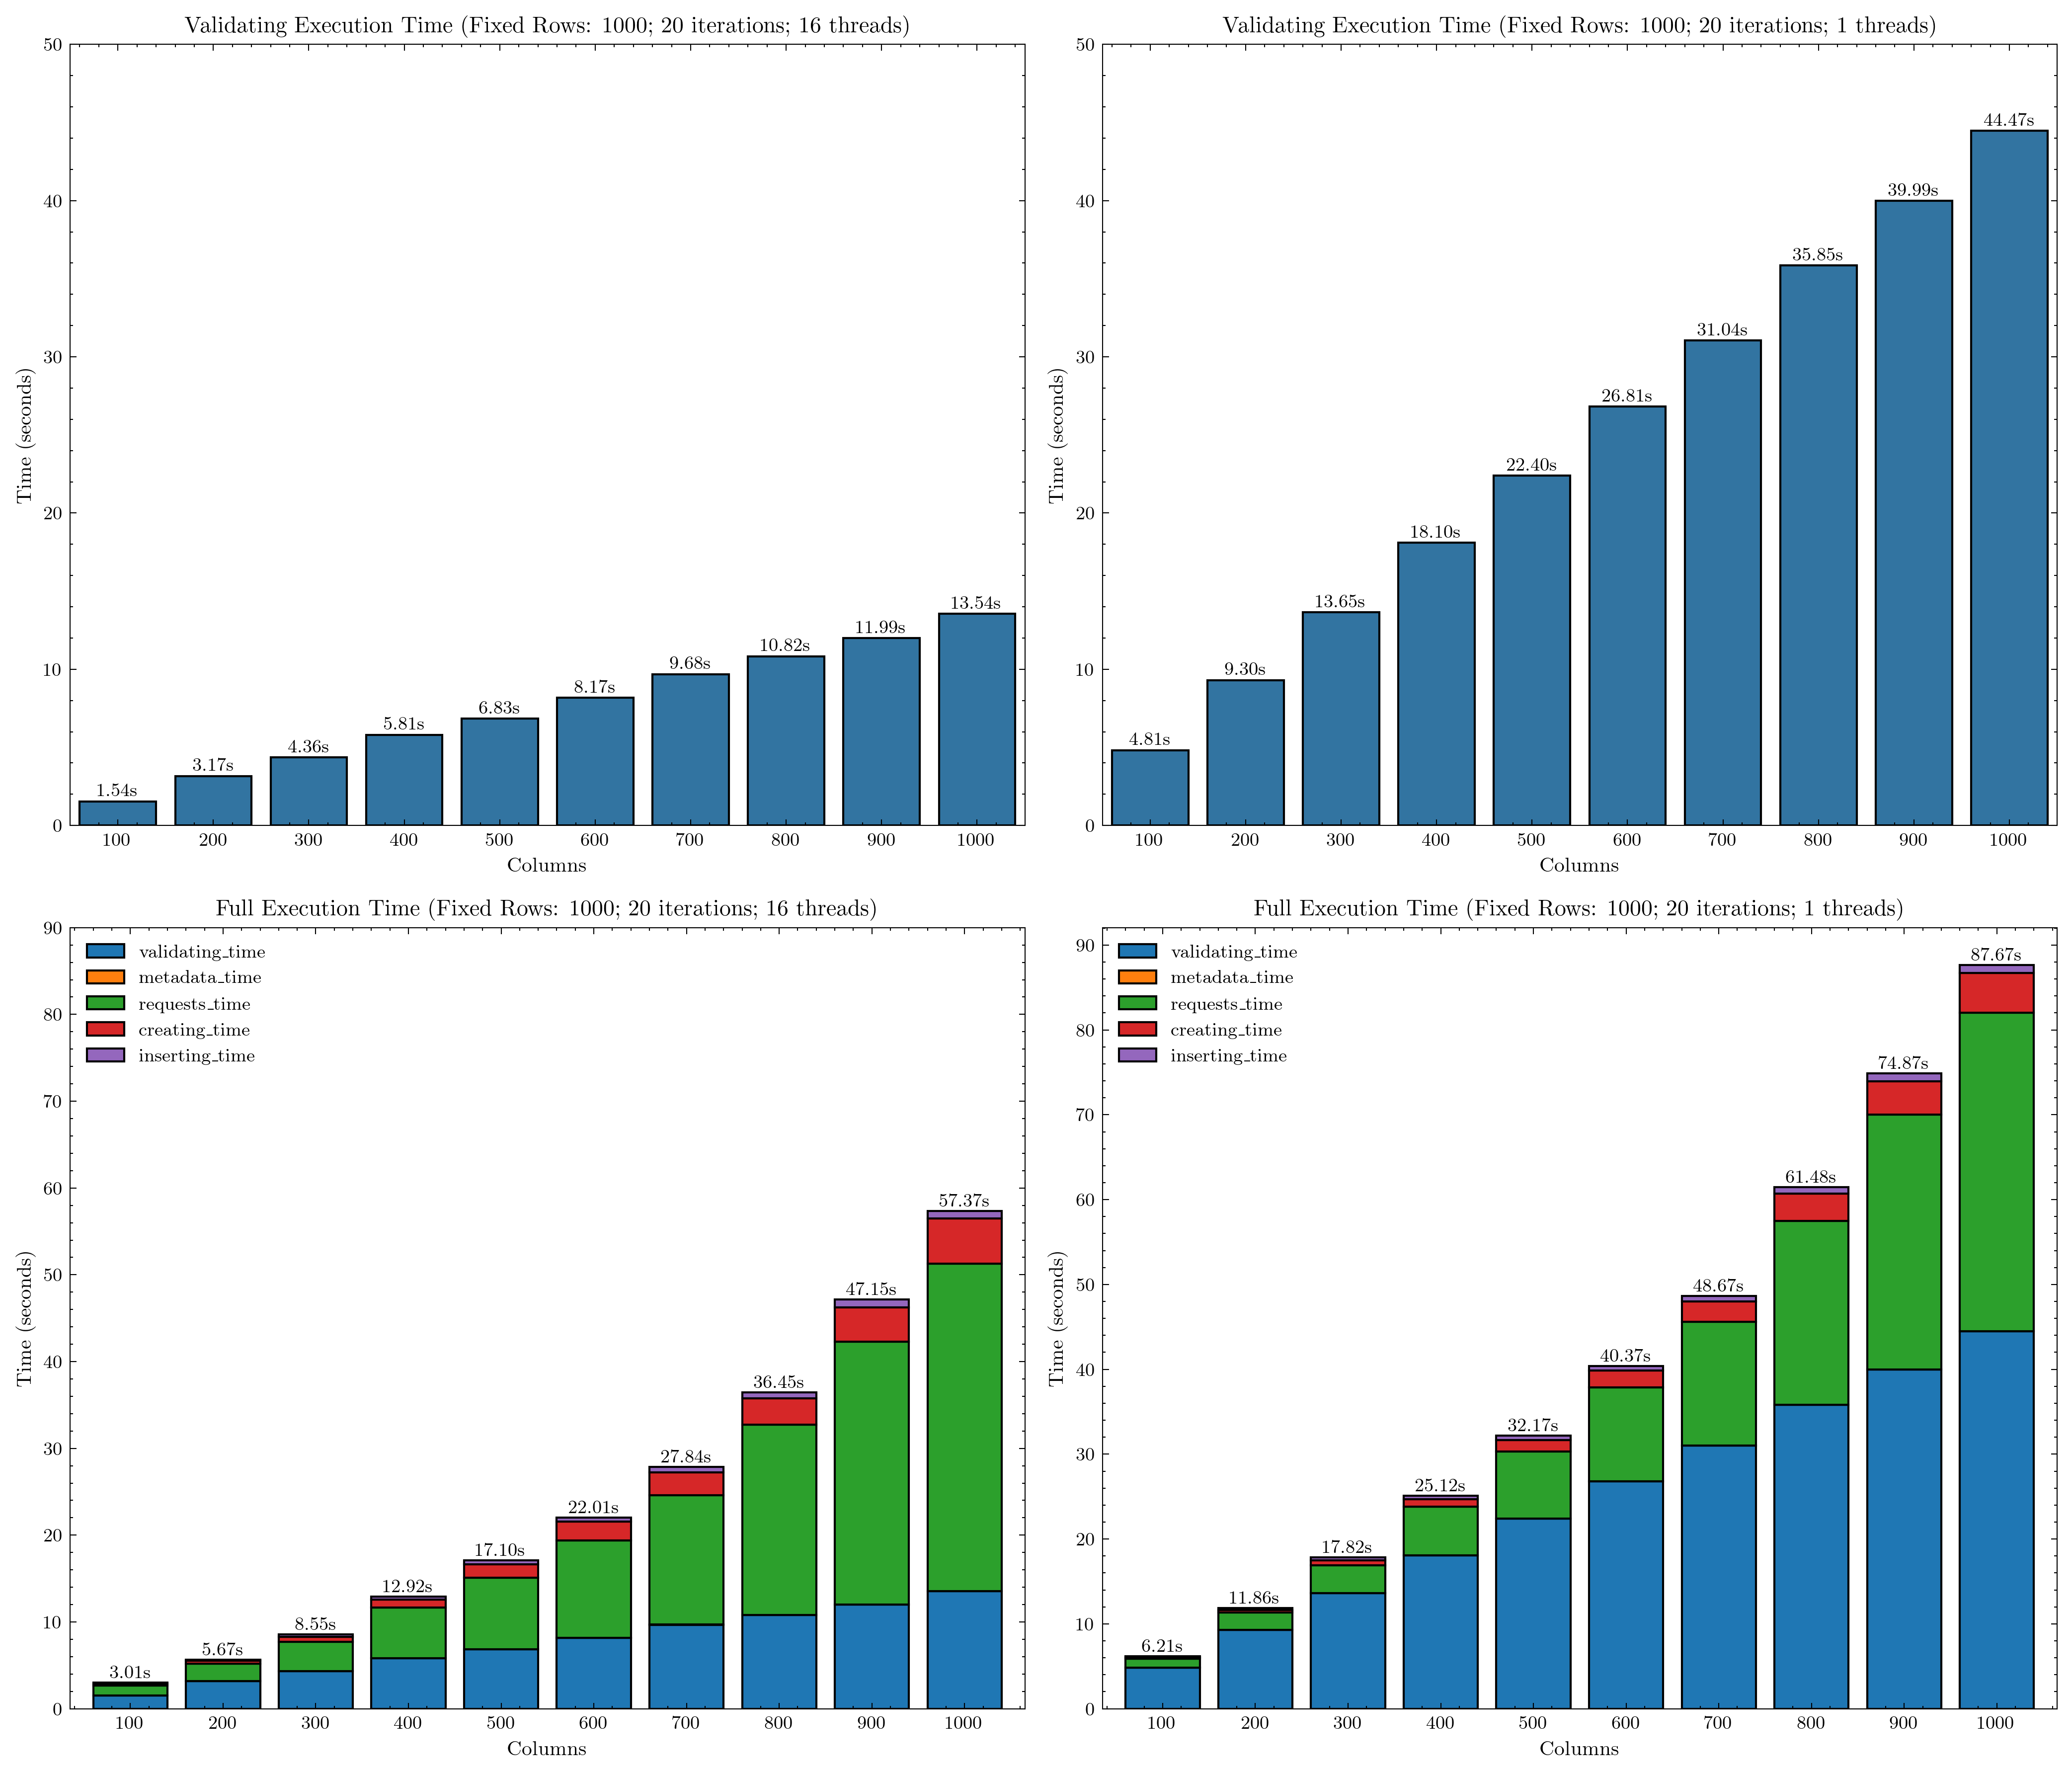

In [123]:
plot_all_results(
    kind=kind,
    amount_fixed=rows_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    save=True,
    suffix=SUFFIX,
    kwargs_full={"yticks": yticks_total_rows, "yticklabels": yticks_total_rows},
    kwargs_validating={
        "yticks": yticks_validating_rows,
        "yticklabels": yticks_validating_rows,
    },
)

### Fixed Columns

In [128]:
kind = "columns"
columns_fixed = 100
spreadsheet_type = "xlsx"
iterations = 20

scale_validating_columns = round(
    get_scale(
        kind,
        amount_fixed=columns_fixed,
        spreadsheet_type=spreadsheet_type,
        iterations=iterations,
        full=False,
        workers=[1, 16],
        multiple=5,
        suffix=SUFFIX,
    )
)

scale_total_columns = round(
    get_scale(
        kind,
        amount_fixed=columns_fixed,
        spreadsheet_type=spreadsheet_type,
        iterations=iterations,
        full=True,
        workers=[1, 16],
        multiple=5,
        suffix=SUFFIX,
    )
)

yticks_validating_columns = list(range(0, scale_validating_columns + 10, 10))
yticks_total_columns = list(range(0, scale_total_columns + 10, 10))

print(
    f"Scale Validating columns: {scale_validating_columns} -- {yticks_validating_columns}"
)
print(f"Scale Total columns: {scale_total_columns} -- {yticks_total_columns}")

Scale Validating columns: 50 -- [0, 10, 20, 30, 40, 50]
Scale Total columns: 55 -- [0, 10, 20, 30, 40, 50, 60]


In [129]:
%%capture
save_each_plot(
    kind=kind,
    amount_fixed=columns_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    suffix=SUFFIX,
    kwargs_full={"yticks": yticks_total_columns, "figsize": (6, 4)},
    kwargs_validating={"yticks": yticks_validating_columns, "figsize": (6, 4)}
)

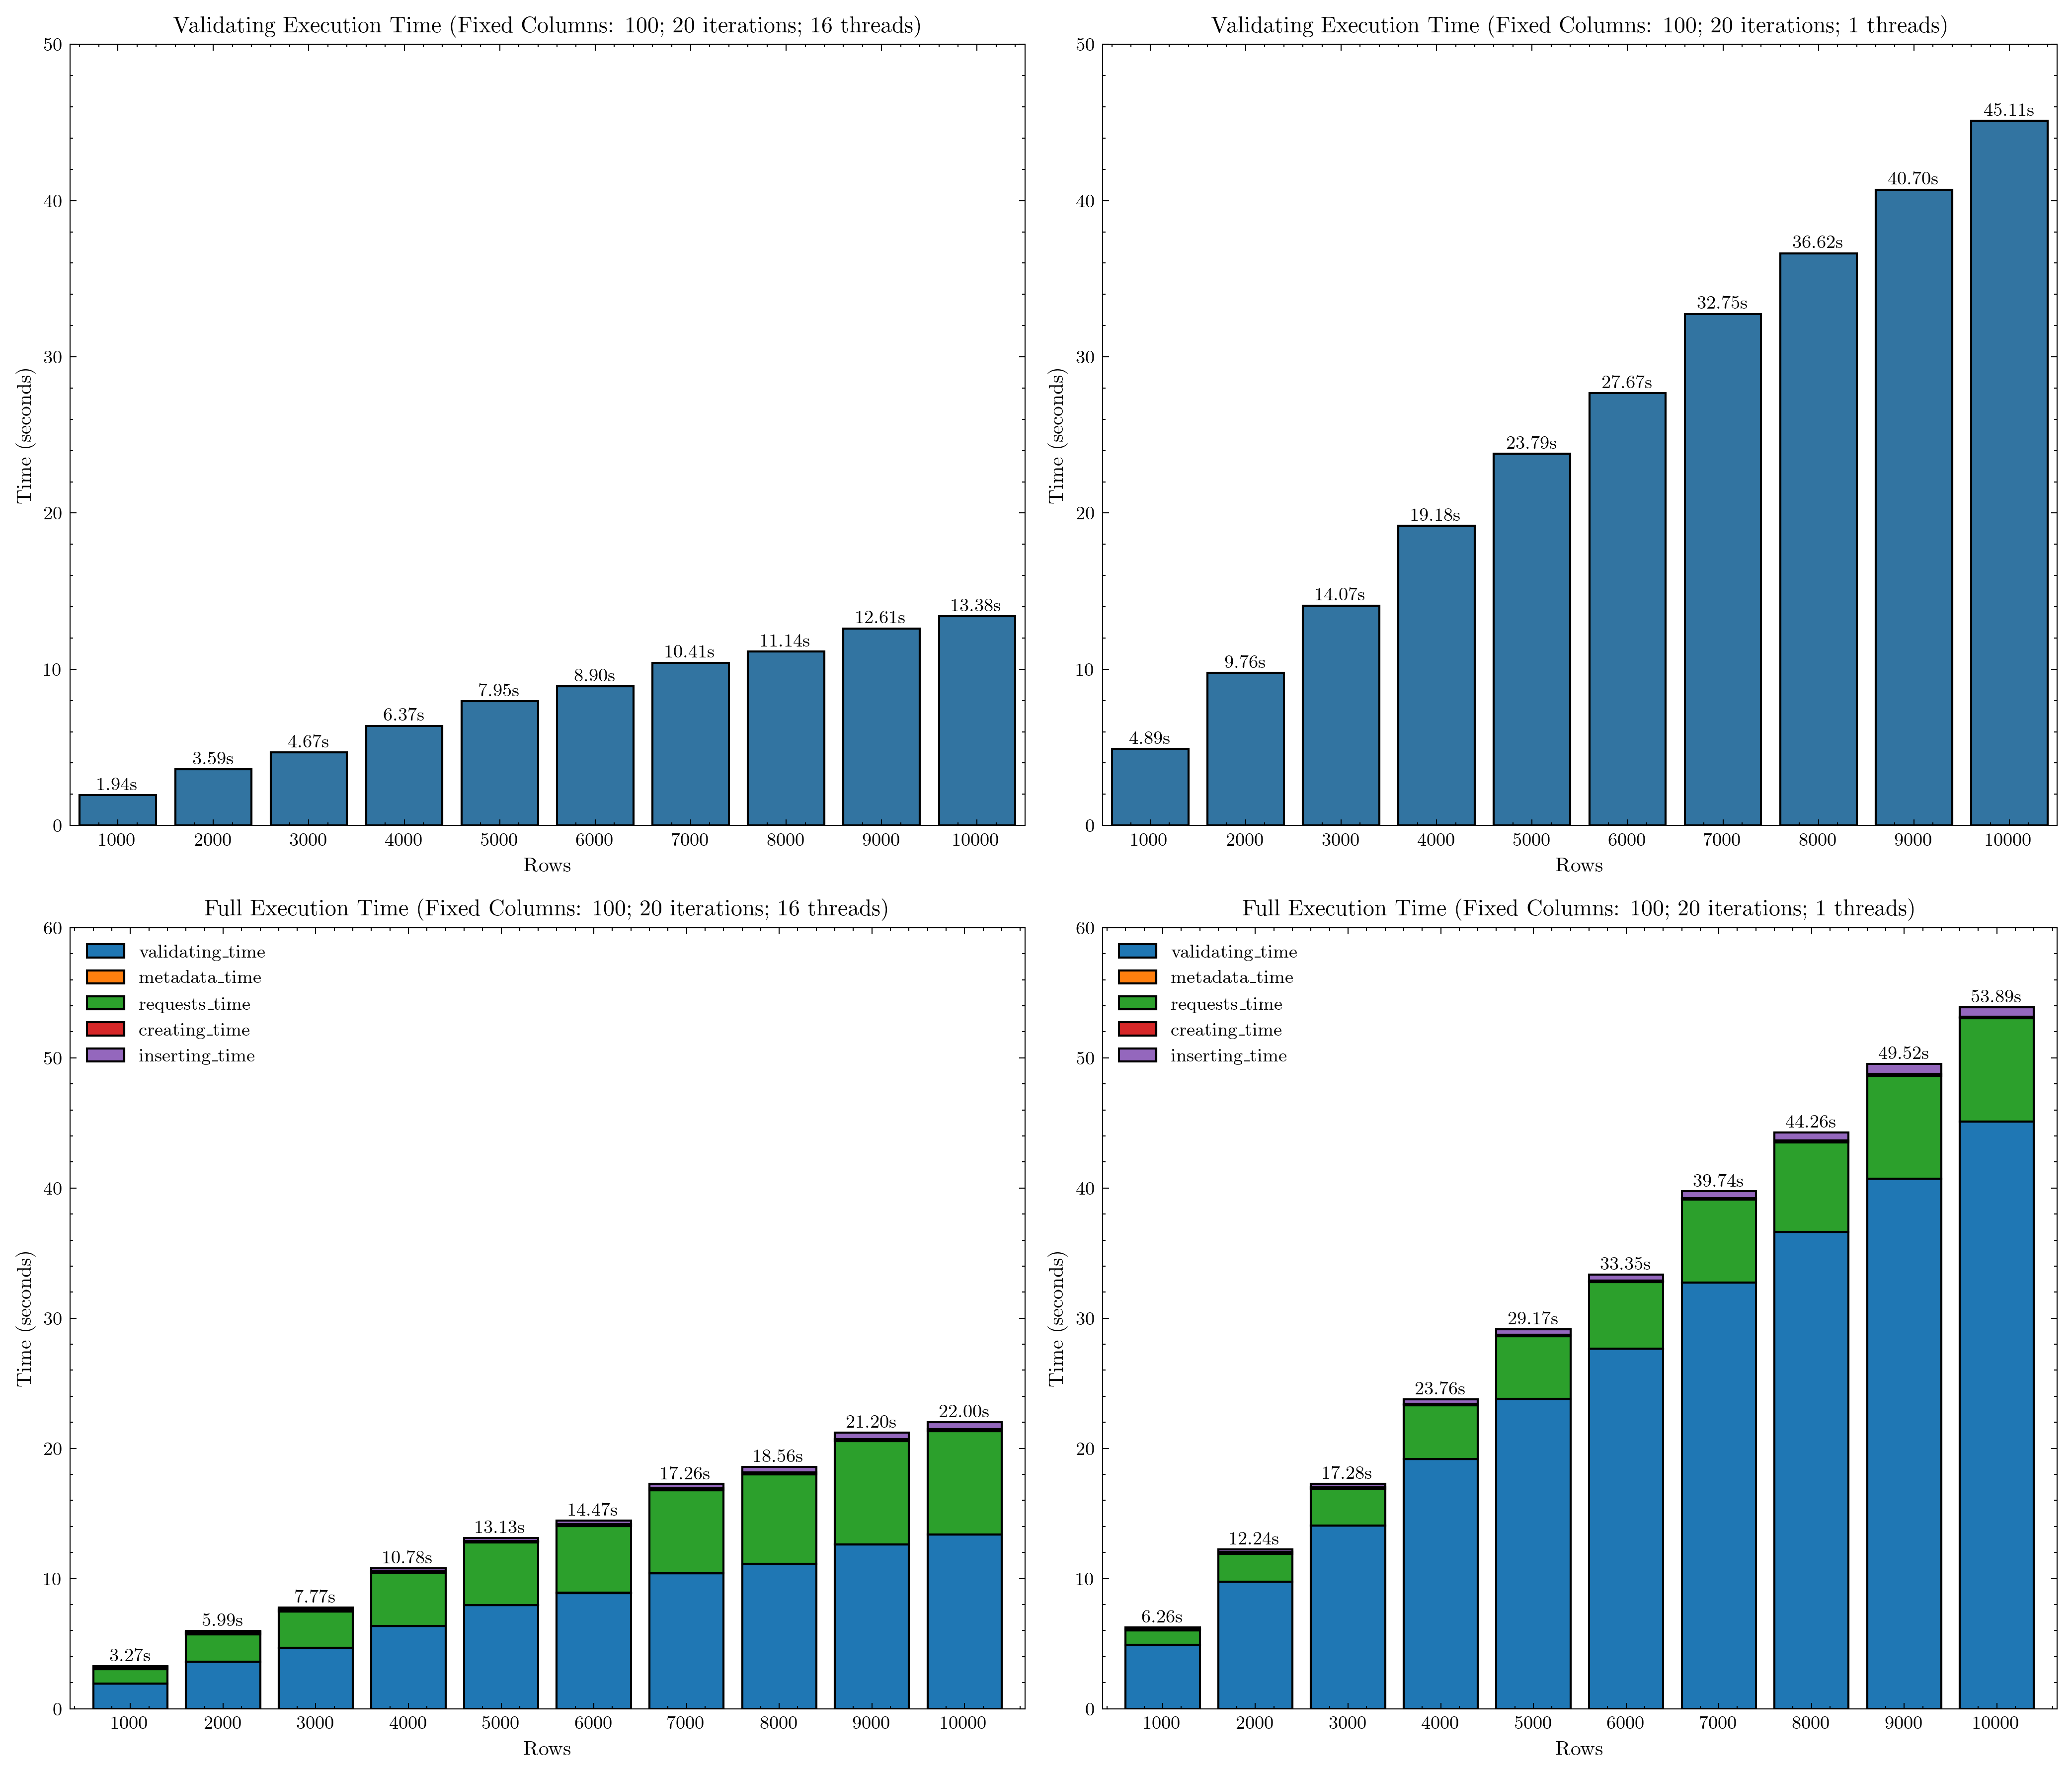

In [130]:
plot_all_results(
    kind=kind,
    amount_fixed=columns_fixed,
    spreadsheet_type=spreadsheet_type,
    iterations=iterations,
    save=True,
    suffix=SUFFIX,
    kwargs_full={"yticks": yticks_total_columns, "yticklabels": yticks_total_columns},
    kwargs_validating={
        "yticks": yticks_validating_columns,
        "yticklabels": yticks_validating_columns,
    },
)